# Momentum Strategy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The previously calculated parameters are loaded below:

In [ ]:
nas100 = pd.read_csv("Data/nas100.csv", index_col = 0)
nas100.index = pd.to_datetime(nas100.index)

log_returns = pd.read_csv("Data/StocksReturns.csv", index_col = 0)
log_returns.index = pd.to_datetime(log_returns.index)

parameters = pd.read_csv('Data/parameters.csv', header = [0, 1], index_col = 0)
parameters.index = pd.to_datetime(parameters.index)

Drop first 180 rows because of the rolling window used for the regression:

In [ ]:
parameters = parameters.iloc[180:]
parameters

R_squared                                                    \
                ADBE       ADP      ABNB     GOOGL      GOOG      AMZN   
Date                                                                     
2014-09-18  0.449808  0.480400       NaN  0.647191       NaN  0.398764   
2014-09-19  0.447107  0.477158       NaN  0.642181       NaN  0.397664   
2014-09-22  0.442175  0.497184       NaN  0.643806       NaN  0.401500   
2014-09-23  0.439458  0.498286       NaN  0.650351       NaN  0.401112   
2014-09-24  0.440638  0.499391       NaN  0.650147       NaN  0.401680   
...              ...       ...       ...       ...       ...       ...   
2023-12-22  0.527815  0.133661  0.231776  0.430441  0.444822  0.465720   
2023-12-26  0.526925  0.133988  0.231999  0.431206  0.445641  0.464812   
2023-12-27  0.525128  0.135428  0.234837  0.429003  0.443564  0.462937   
2023-12-28  0.525989  0.136386  0.232808  0.428486  0.442613  0.460116   
2023-12-29  0.522396  0.134500  0.232771  0.422466  0.435976  0.451480   

                                                    ... alpha_significativity  \
                 AMD       AEP      AMGN       ADI  ...                   FOX   
Date                                                ...                         
2014-09-18  0.057291  0.041645  0.426580  0.304649  ...                   NaN   
2014-09-19  0.060203  0.038610  0.435604  0.301991  ...                   NaN   
2014-09-22  0.062891  0.039882  0.436357  0.305764  ...                   NaN   
2014-09-23  0.065733  0.040304  0.435918  0.305539  ...                   NaN   
2014-09-24  0.064764  0.038483  0.434574  0.306026  ...                   NaN   
...              ...       ...       ...       ...  ...                   ...   
2023-12-22  0.474742  0.014408  0.053885  0.346127  ...              0.238298   
2023-12-26  0.479924  0.014546  0.053444  0.351466  ...              0.207805   
2023-12-27  0.478104  0.014584  0.053759  0.350505  ...              0.169243   
2023-12-28  0.474856  0.014489  0.052234  0.348207  ...              0.195831   
2023-12-29  0.486783  0.015208  0.050984  0.349175  ...              0.198821   

                                                                        \
               QRTEA      SRCL       WOR      STRM      ASAI      CHRS   
Date                                                                     
2014-09-18  0.135746  0.569469  0.203826  0.120993       NaN       NaN   
2014-09-19  0.139321  0.664897  0.164900  0.154795       NaN       NaN   
2014-09-22  0.101066  0.602577  0.114866  0.131554       NaN       NaN   
2014-09-23  0.066070  0.553046  0.127295  0.156352       NaN       NaN   
2014-09-24  0.108638  0.477511  0.121717  0.166116       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-12-22  0.722069  0.879915  0.288424  0.297431  0.803673  0.084521   
2023-12-26  0.675171  0.922242  0.301135  0.369829  0.784676  0.093728   
2023-12-27  0.571571  0.995087  0.331275  0.355408  0.645383  0.156021   
2023-12-28  0.694472  0.985948  0.341780  0.332306  0.634484  0.233252   
2023-12-29  0.696692  0.980792  0.345989  0.293415  0.691748  0.237064   

                                          
                LOGI      CHKP     LBTYA  
Date                                      
2014-09-18  0.624716  0.988522  0.393331  
2014-09-19  0.649210  0.932172  0.461407  
2014-09-22  0.613276  0.894433  0.416033  
2014-09-23  0.570491  0.894129  0.337650  
2014-09-24  0.531367  0.973701  0.386390  
...              ...       ...       ...  
2023-12-22  0.253117  0.839426  0.313527  
2023-12-26  0.251935  0.771081  0.354195  
2023-12-27  0.228287  0.803461  0.339745  
2023-12-28  0.249644  0.917496  0.386056  
2023-12-29  0.240161  0.921239  0.429479  

[2337 rows x 1856 columns]

In [ ]:
start_date = parameters.index[0]
start_date

Timestamp('2014-09-18 00:00:00')

Then we align the other two dataframes to the correct starting date:

In [ ]:
log_returns = log_returns[log_returns.index >= start_date]
nas100 = nas100[nas100.index >= start_date]

Extract list of mondays in the considered period, they will be used as rebalancing day for the tilted portfolios:

In [ ]:
mondays = parameters.index[parameters.index.weekday == 0]

To calculate the momentum of each stock we load the previously downloaded prices:

In [ ]:
prices = pd.read_csv('Data/StocksPrices.csv')
prices.Date = pd.to_datetime(prices.Date)
prices.set_index('Date', inplace = True )
prices

,ADBE,ADP,ABNB,GOOGL,GOOG,AMZN,AMD,AEP,AMGN,ADI,...,SRCL,WOR,STRM,ASAI,CHRS,CA,AAL,LOGI,CHKP,LBTYA
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,59.880001,70.939423,NaN,28.045795,NaN,19.939501,3.870000,46.740002,114.080002,50.930000,...,116.169998,25.943279,6.98,NaN,NaN,NaN,25.250000,13.690000,64.500000,45.477772
2014-01-02,59.290001,70.114136,NaN,27.855856,NaN,19.898500,3.950000,46.130001,115.800003,49.279999,...,114.879997,25.659679,6.75,NaN,NaN,NaN,25.360001,13.350000,64.379997,45.344917
2014-01-03,59.160000,70.877960,NaN,27.652653,NaN,19.822001,4.000000,46.110001,114.470001,49.610001,...,115.050003,26.331690,6.83,NaN,NaN,NaN,26.540001,13.400000,64.290001,45.273376
2014-01-06,58.119999,70.070236,NaN,27.960960,NaN,19.681499,4.130000,46.080002,113.480003,49.330002,...,114.750000,25.856968,6.79,NaN,NaN,NaN,27.030001,13.590000,63.919998,45.978539
2014-01-07,58.970001,70.921860,NaN,28.500000,NaN,19.901501,4.180000,46.380001,116.430000,49.590000,...,116.059998,25.930948,6.85,NaN,NaN,NaN,26.910000,14.050000,63.939999,45.871231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,598.750000,230.970001,140.800003,141.490005,142.720001,153.419998,139.600006,80.379997,284.160004,197.100006,...,50.450001,58.430000,0.41,13.89,2.02,25.315001,14.310000,92.580002,152.250000,17.180000
2023-12-26,598.260010,232.539993,138.720001,141.520004,142.820007,153.410004,143.410004,80.730003,283.899994,198.869995,...,50.320000,58.869999,0.50,13.99,2.18,25.325001,14.110000,93.230003,153.639999,17.540001
2023-12-27,596.080017,231.610001,136.550003,140.369995,141.440002,153.339996,146.070007,80.809998,286.529999,199.350006,...,49.849998,58.880001,0.48,14.00,2.69,25.405001,13.990000,94.559998,153.100006,17.500000


We then calculate the **HQM Score** , i.e. the arithmetic mean of the Momentum indicators based on different time periods: 180, 90, 60, 30 and 7 days respectively:

In [ ]:
HQM_score = {
    'HQM_score': {}
}

HQM_score['HQM_score'] = (
    ((prices - prices.shift(180)) / prices.shift(180)) * 100 +
    ((prices - prices.shift(90)) / prices.shift(90)) * 100 +
    ((prices - prices.shift(60)) / prices.shift(60)) * 100 +
    ((prices - prices.shift(30)) / prices.shift(30)) * 100 +
    ((prices - prices.shift(7)) / prices.shift(7)) * 100
                         ) / 5

HQM_score_df = {k: pd.DataFrame(v) for k, v in HQM_score.items()}
HQM_score_df = pd.concat(HQM_score_df, axis=1)

In [ ]:
HQM_score_df = HQM_score_df.iloc[180:]
HQM_score_df

HQM_score                                                        \
                 ADBE       ADP       ABNB      GOOGL       GOOG       AMZN   
Date                                                                          
2014-09-18   2.483193  4.572454        NaN   5.317840        NaN  -1.767012   
2014-09-19   1.325343  4.448440        NaN   6.334985        NaN  -0.085570   
2014-09-22   1.453537  3.330694        NaN   5.256383        NaN  -1.774206   
2014-09-23   3.438726  3.229822        NaN   4.373675        NaN  -1.811218   
2014-09-24   4.606152  4.293255        NaN   5.618470        NaN  -0.423782   
...               ...       ...        ...        ...        ...        ...   
2023-12-22  18.377361 -1.524639  12.028459  12.548856  12.741588  19.577061   
2023-12-26  19.152335 -0.311823   8.858388  12.805631  13.017980  19.251921   
2023-12-27  19.046747 -0.424315   7.289386  12.023882  11.968362  19.359531   
2023-12-28  18.162231 -0.598210   8.126734  11.469937  11.427446  19.679496   
2023-12-29  17.262075 -0.627295   6.438606   9.505968   9.546708  17.218807   

                                                       ...             \
                  AMD       AEP       AMGN        ADI  ...       SRCL   
Date                                                   ...              
2014-09-18  -2.851726  3.556937  17.254933  -2.030625  ...   0.300939   
2014-09-19  -5.296414  4.324237  18.579419  -1.111722  ...   0.563868   
2014-09-22  -6.961679  3.227303  16.945395  -1.459585  ...  -0.042310   
2014-09-23  -9.075731  2.931339  16.533476  -1.611317  ...  -0.427302   
2014-09-24  -9.164505  2.089206  17.019857  -1.569544  ...  -0.669822   
...               ...       ...        ...        ...  ...        ...   
2023-12-22  28.216245 -1.184112   6.567208   9.745406  ...  13.712447   
2023-12-26  30.367719 -0.787443   7.066880   9.161976  ...  13.025583   
2023-12-27  33.070632  1.280133   8.490487   9.672136  ...  12.626859   
2023-12-28  35.681782  1.216963   9.664240  10.254450  ...  12.889457   
2023-12-29  34.266833  1.115848   8.757195   8.371265  ...  11.830255   

                                                                     \
                  WOR       STRM      ASAI       CHRS  CA       AAL   
Date                                                                  
2014-09-18  -2.787778 -25.899498       NaN        NaN NaN  7.444558   
2014-09-19  -5.073757 -20.578042       NaN        NaN NaN  3.072936   
2014-09-22  -5.693930 -22.149475       NaN        NaN NaN -1.071864   
2014-09-23  -6.291492 -18.310910       NaN        NaN NaN -1.920330   
2014-09-24  -5.808145 -18.352711       NaN        NaN NaN  1.150894   
...               ...        ...       ...        ...  ..       ...   
2023-12-22  40.145752 -31.548146  7.783290 -33.071836 NaN  5.785966   
2023-12-26  39.400929 -20.500995  6.970388 -26.380125 NaN  3.981224   
2023-12-27  38.899419 -22.512019  6.730376 -10.050628 NaN  3.149918   
2023-12-28  36.352222 -26.630851  6.957429   9.371403 NaN  5.160486   
2023-12-29  34.692422 -26.708987  6.306585  11.969888 NaN  2.679273   

                                            
                 LOGI       CHKP     LBTYA  
Date                                        
2014-09-18  -3.063296   6.066548  0.921928  
2014-09-19  -3.381303   5.800486  2.627219  
2014-09-22  -4.306295   5.117593  0.349290  
2014-09-23  -4.351067   4.352583 -0.723902  
2014-09-24  -3.221703   6.563732  0.722983  
...               ...        ...       ...  
2023-12-22  30.043936  11.617214 -0.210796  
2023-12-26  30.413665  12.707546  1.136931  
2023-12-27  32.510197  11.959939  3.439468  
2023-12-28  31.712139  11.006713  4.128958  
2023-12-29  30.652694  10.775390  4.594293  

[2337 rows x 238 columns]

### NEW PORTFOLIOS

In [ ]:
sharpe = parameters["mean_return_real"] / parameters["variance_stock"]
sharpe.head()

,ADBE,ADP,ABNB,GOOGL,GOOG,AMZN,AMD,AEP,AMGN,ADI,...,FOX,QRTEA,SRCL,WOR,STRM,ASAI,CHRS,LOGI,CHKP,LBTYA
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-18,3.023396,3.404943,NaN,1.884719,NaN,-2.430503,0.020074,6.143969,5.747084,-0.521864,...,NaN,-0.703568,0.749794,-1.500614,-3.115139,NaN,NaN,-0.327005,4.193486,-1.442560
2014-09-19,2.907564,4.112416,NaN,2.485425,NaN,-2.166595,-0.280901,7.369359,5.723736,0.617190,...,NaN,-0.322635,2.310897,-1.794271,-2.828308,NaN,NaN,-0.195716,4.035686,-0.703680
2014-09-22,3.052898,2.416644,NaN,2.290785,NaN,-2.356230,-0.481636,7.077699,5.686289,0.269253,...,NaN,-1.078164,1.435435,-2.452788,-3.004933,NaN,NaN,-0.335188,3.692415,-1.111433
2014-09-23,3.712238,2.916545,NaN,1.655429,NaN,-2.305035,-0.881835,6.690134,5.629745,0.296979,...,NaN,-1.898617,0.790717,-2.238515,-2.799503,NaN,NaN,-0.483982,3.720608,-1.784007
2014-09-24,3.789001,3.207246,NaN,1.458521,NaN,-2.268310,-0.955976,6.281889,5.316767,0.355756,...,NaN,-0.750353,-0.318833,-2.303939,-2.706971,NaN,NaN,-0.640657,4.368075,-1.209669


In [ ]:
composition = pd.read_csv("Data/nas_comps.csv", index_col = 0)
composition.index = pd.to_datetime(composition.index, format = "mixed")
composition

,components
2024-07-20,"['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN..."
2024-03-18,"['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN..."
2023-12-18,"['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN..."
2023-07-17,"['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN..."
2023-06-20,"['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN..."
...,...
1995-07-05,"['ADBE', 'AMGN', 'AAPL', 'AMAT', 'ARM', 'CSCO'..."
1995-03-06,"['ADBE', 'AMGN', 'AAPL', 'AMAT', 'ARM', 'CSCO'..."
1995-02-27,"['ADBE', 'AMGN', 'AAPL', 'AMAT', 'ARM', 'CSCO'..."
1995-02-13,"['ADBE', 'AMGN', 'AAPL', 'AMAT', 'ARM', 'CSCO'..."


We define a function that is going to be used to retrieve the composition of the index at a specific point in time:

In [ ]:
import ast

def get_composition(date, df):
    closest_date = df.index[df.index < date][-1]
    composition_string = df.loc[closest_date].values[0]
    composition_list = ast.literal_eval(composition_string)
    return composition_list

## BUILD TILTED PORTFOLIOS WITH TOP 10 STOCKS VS TOP 10 MOMENTUM STOCKS PER *PARAMETER*

We start by defining a function that will be used to buid tilted portfolios and show graphically the performance
of tilted portfolios compared to the nas100 benchmark:

In [ ]:
def momentum_portfolio_performance(metric_df, log_returns, nas100, metric_name, n_stocks, composition_df):

    # We create a list of Monday dates, where we are going to rebalance portfolios
    mondays = metric_df.index[metric_df.index.weekday == 0]

    momentum_scores = HQM_score_df['HQM_score']

    # We initialise the values of the portfolios and the entire NAS100 benchmark series already normalized to start from 100
    portfolio_top_val = [100]
    portfolio_momentum_val = [100]
    nas100_val = (nas100.Close / nas100.Close.loc[mondays[0]] * 100).loc[mondays]

    # We initialise lists to keep track of selected stocks
    top_stocks_list = []
    momentum_stocks_list = []

    for i in range(len(mondays) - 1):
        current_monday = mondays[i]
        next_monday = mondays[i + 1]

        comps = get_composition(current_monday, composition_df)
        valid_tickers = [ticker for ticker in comps if ticker in metric_df.columns]

        # We select the values of the generic parameter for the current Monday
        metric_values = metric_df.loc[current_monday, valid_tickers]

        pre_selection_stocks = metric_values.nlargest(2*n_stocks).index
        momentum_values = momentum_scores.loc[current_monday, pre_selection_stocks]

        # We identify the top and bottom stocks
        top_stocks = metric_values.nlargest(n_stocks).index
        momentum_stocks = momentum_values.nlargest(n_stocks).index

        # Adding selected stocks to list
        top_stocks_list.append((current_monday, top_stocks))
        momentum_stocks_list.append((current_monday, momentum_stocks))

        # We calculate the weekly returns of the top and bottom 10 stocks for the current week
        weekly_returns_top = log_returns.loc[current_monday:next_monday, top_stocks].sum()
        weekly_returns_momentum = log_returns.loc[current_monday:next_monday, momentum_stocks].sum()

        # We calculate the average of the weekly logarithmic returns
        mean_weekly_returns_top = weekly_returns_top.mean()
        mean_weekly_returns_momentum = weekly_returns_momentum.mean()

        # Updating the value of portfolios
        new_val_top = portfolio_top_val[-1] * np.exp(mean_weekly_returns_top)
        new_val_momentum = portfolio_momentum_val[-1] * np.exp(mean_weekly_returns_momentum)

        portfolio_top_val.append(new_val_top)
        portfolio_momentum_val.append(new_val_momentum)

    # We create a DataFrame for portfolio values
    portfolios_values = pd.DataFrame({
        'Date': mondays,
        f'Portfolio Top {n_stocks} {metric_name}': portfolio_top_val,
        f'Portfolio Momentum {n_stocks} {metric_name}': portfolio_momentum_val,
        'NAS100 Index': nas100_val
    })
    portfolios_values.set_index('Date', inplace = True)

    # We create a graph to display the results (performance of two portfolios against the benchmarck)
    plt.figure(figsize = (14, 7))
    plt.plot(portfolios_values[f'Portfolio Top {n_stocks} {metric_name}'], label = f'Portfolio Top {n_stocks} {metric_name}')
    plt.plot(portfolios_values[f'Portfolio Momentum {n_stocks} {metric_name}'], label = f'Portfolio Momentum {n_stocks} {metric_name}')
    plt.plot(portfolios_values['NAS100 Index'], label = 'NAS100 Index', linestyle = '--')
    plt.legend()
    plt.title(f'Performance of Portfolios with NAS Index Comparison based on {metric_name}')
    plt.xlabel('Date')
    plt.ylabel('Portfolios values')
    plt.show()

    # Compute some basic stats
    mean_top = portfolios_values[f'Portfolio Top {n_stocks} {metric_name}'].pct_change().mean()
    mean_bottom = portfolios_values[f'Portfolio Momentum {n_stocks} {metric_name}'].pct_change().mean()
    volatility_top = portfolios_values[f'Portfolio Top {n_stocks} {metric_name}'].pct_change().std()
    volatility_bottom = portfolios_values[f'Portfolio Momentum {n_stocks} {metric_name}'].pct_change().std()
    mean_nas = portfolios_values['NAS100 Index'].pct_change().mean()
    volatility_nas = portfolios_values['NAS100 Index'].pct_change().std()

    print(f"Mean performance Top portfolio: {mean_top:.4f}")
    print(f"Mean performance Momentum portfolio: {mean_bottom:.4f}")
    print(f"Mean performance NAS100 Index: {mean_nas:.4f}")
    print(f"Volatility Top portfolio: {volatility_top:.4f}")
    print(f"Volatility Momentum portfolio: {volatility_bottom:.4f}")
    print(f"Volatility NAS100 Index: {volatility_nas:.4f}")

    # We save selected stocks in a DataFrame for later review
    top_stocks_df = pd.DataFrame(top_stocks_list, columns = ['Date', f'Top {n_stocks} {metric_name} Stocks']).set_index('Date')
    momentum_stocks_df = pd.DataFrame(momentum_stocks_list, columns = ['Date', f'Bottom {n_stocks} {metric_name} Stocks']).set_index('Date')

    return portfolios_values, top_stocks_df, momentum_stocks_df

Then we define a function to compute different metrics to evaluate portfolio performance for every year considered:

In [ ]:
def compute_metrics(portfolios_values):
    # Create a list of the year in the considered period
    portfolios_values['Year'] = portfolios_values.index.year

    # Dict to store results
    results = {'Year': [], 'Portfolio': [], 'Mean Yearly Return': [],
                 'Mean Yearly Volatility': [], 'Efficiency (Sharpe Ratio)': [],
                 'Max Drawdown': [], 'VaR 95%': []}

    # Iterates on each portfolio
    for portfolio in portfolios_values.columns:
        for year, yearly_data in portfolios_values.groupby('Year'):
            # Compute weekly returns
            returns = yearly_data[portfolio].pct_change().dropna()

            # Compute metrics
            mean_yearly_return = returns.mean() * 52
            yearly_volatility = returns.std() * np.sqrt(52)
            efficiency = mean_yearly_return / yearly_volatility if yearly_volatility != 0 else np.nan
            cumulative = (1 + returns).cumprod()
            max_drawdown = (cumulative / cumulative.cummax() - 1).min()
            var_95 = np.percentile(returns, 5)

            # Insert results in the dict
            results['Year'].append(year)
            results['Portfolio'].append(portfolio)
            results['Mean Yearly Return'].append(mean_yearly_return)
            results['Mean Yearly Volatility'].append(yearly_volatility)
            results['Efficiency (Sharpe Ratio)'].append(efficiency)
            results['Max Drawdown'].append(max_drawdown)
            results['VaR 95%'].append(var_95)

    results_df = pd.DataFrame(results)
    results_df = results_df.iloc[:-10]
    return results_df

We define our last function to plot the metrics obtained:

In [ ]:
def plot_grouped_bar(performance_df):
    # Define Metrics to compute
    metrics = ['Mean Yearly Return', 'Mean Yearly Volatility', 'Efficiency (Sharpe Ratio)', 'Max Drawdown', 'VaR 95%']
    portfolios = performance_df['Portfolio'].unique()
    portfolios = [p for p in portfolios if p != 'Year']
    colors = ['blue', 'orange', 'green']  # Colors for represent the 3 differents portfolios

    # We create a 2x3 layout to plot 5 subgraphs
    fig, axes = plt.subplots(3, 2, figsize = (12, 12))
    axes = axes.flatten()

    bar_width = 0.2  # Bars' widht
    space_between_groups = 0.5  # Bars' spacing (different years)
    years = performance_df['Year'].unique()  # Years

    # Cycle on each metric
    for i, metric in enumerate(metrics):
        ax = axes[i]

        # We define the centre position of each group of bars
        positions = np.arange(len(years)) * (bar_width * len(portfolios) + space_between_groups)

        for j, portfolio in enumerate(portfolios):
            # We select data for current portfolio
            data = performance_df[performance_df['Portfolio'] == portfolio].sort_values('Year')

            # We position the bars for each portfolio with a shift within the group
            ax.bar(positions + j * bar_width, data[metric], width = bar_width, label = portfolio, color = colors[j], edgecolor = 'black', linewidth = 0.8)

        # Graph settings
        ax.axhline(0, color = 'black', linewidth = 0.8)  # Zero line
        ax.set_title(metric)
        ax.set_xlabel('Anno')
        ax.set_ylabel(metric)
        ax.grid(True)

        ax.set_xticks(positions + bar_width)
        ax.set_xticklabels(years, rotation=45)

    # Remove last subplot (it's empty)
    fig.delaxes(axes[5])

    # Add one unique legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc = 'upper center', ncol = 3, fontsize = 10, bbox_to_anchor = (0.5, 1.1))

    plt.tight_layout()
    plt.show()


#### Example of the use of the function using R-squared:

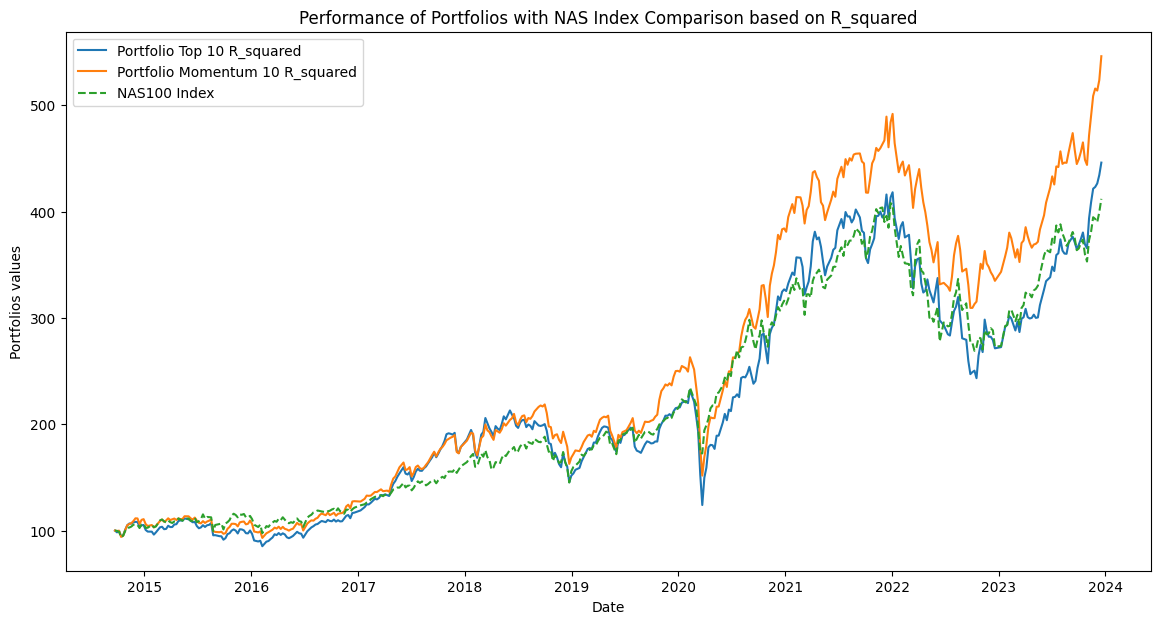

Mean performance Top portfolio: 0.0041
Mean performance Momentum portfolio: 0.0045
Mean performance NAS100 Index: 0.0037
Volatility Top portfolio: 0.0374
Volatility Momentum portfolio: 0.0333
Volatility NAS100 Index: 0.0309


In [ ]:
portfolios_values, top_stocks_df, momentum_stocks_df = momentum_portfolio_performance(parameters["R_squared"], log_returns, nas100, 'R_squared', 10, composition)

Application of metric function:

In [ ]:
performance_df = compute_metrics(portfolios_values)
performance_df

,Year,Portfolio,Mean Yearly Return,Mean Yearly Volatility,Efficiency (Sharpe Ratio),Max Drawdown,VaR 95%
0,2014,Portfolio Top 10 R_squared,0.209219,0.201173,1.039994,-0.050892,-0.045268
1,2015,Portfolio Top 10 R_squared,0.011395,0.184493,0.061765,-0.179590,-0.031925
2,2016,Portfolio Top 10 R_squared,0.233175,0.179373,1.299946,-0.059529,-0.036405
3,2017,Portfolio Top 10 R_squared,0.488621,0.181231,2.696123,-0.099474,-0.035495
4,2018,Portfolio Top 10 R_squared,-0.180771,0.297238,-0.608169,-0.317413,-0.059579
5,2019,Portfolio Top 10 R_squared,0.394898,0.194504,2.030284,-0.125619,-0.040716
6,2020,Portfolio Top 10 R_squared,0.581613,0.488778,1.189933,-0.465929,-0.069062
7,2021,Portfolio Top 10 R_squared,0.296573,0.227204,1.305317,-0.125328,-0.047347
8,2022,Portfolio Top 10 R_squared,-0.453468,0.335112,-1.353181,-0.382336,-0.070549
9,2023,Portfolio Top 10 R_squared,0.602259,0.186707,3.225687,-0.049888,-0.029252


Application of plotting function:

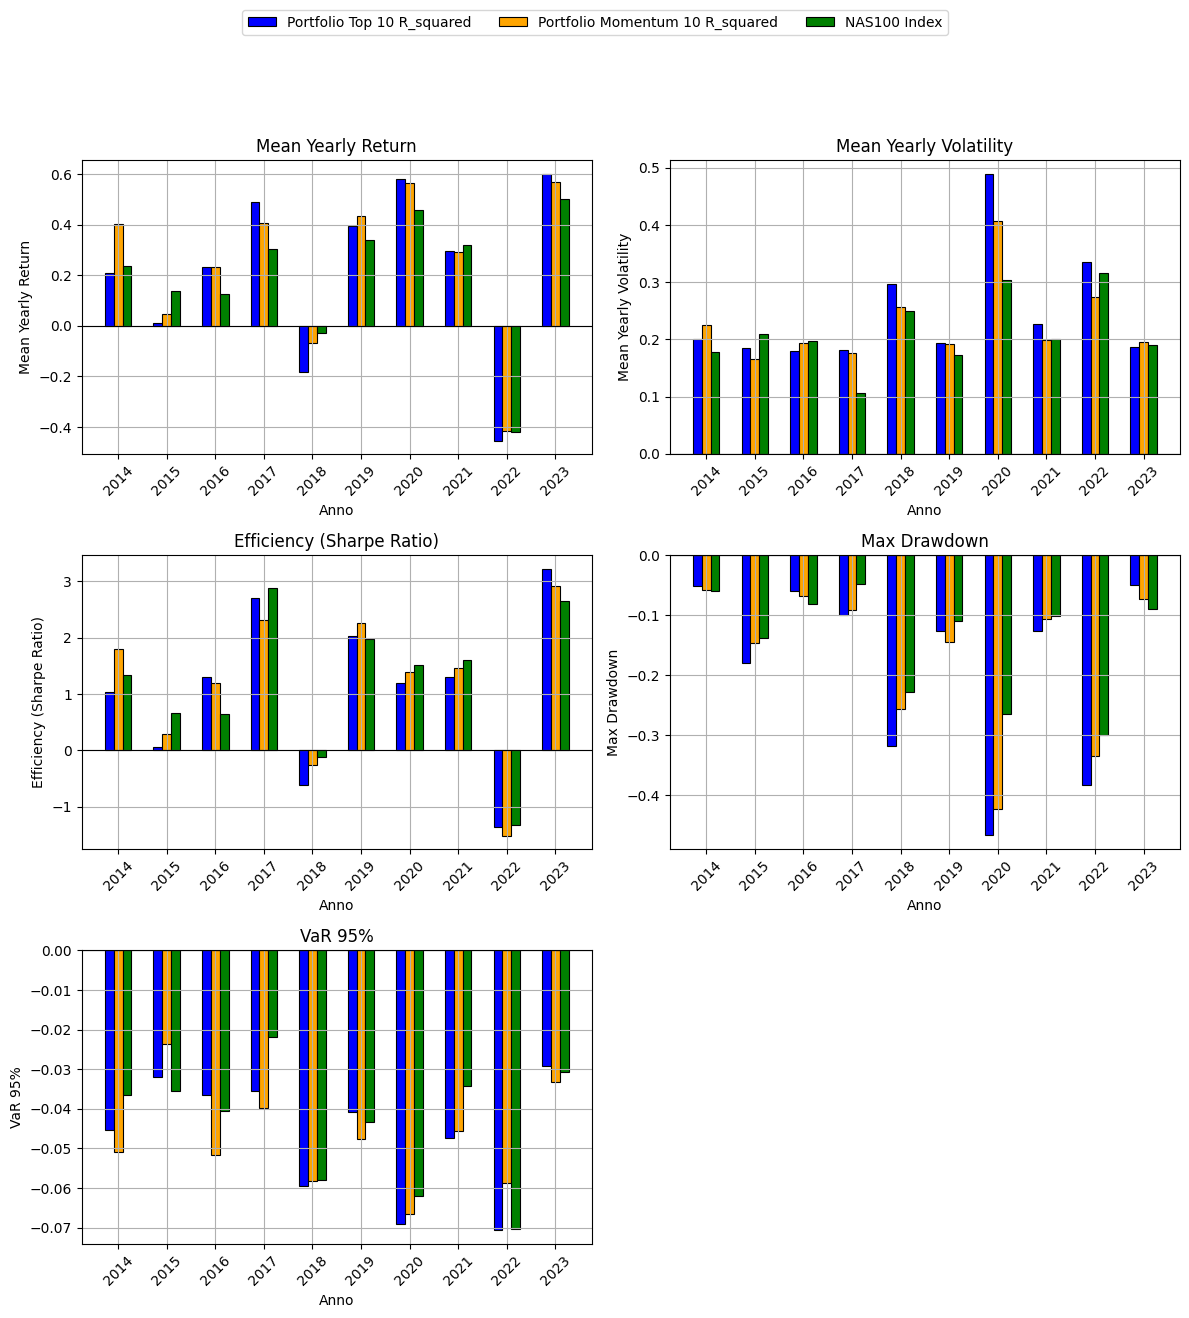

In [ ]:
plot_grouped_bar(performance_df)